## Train Pipeline with XGBClassifier

### Set Up

In [1]:
import orbital
import duckdb
import sqlglot
import skl2onnx
import pandas as pd 
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from skl2onnx import update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost

In [2]:
# make data dataset
X,y = make_classification()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# get column names for use in pipeline
## onnxmltools forces these to be formatted as "f<number>"
n_cols = len(X_train[0])
nm_cols = [f"f{i}" for i in range(n_cols)]
feat_dict = {c:orbital.types.DoubleColumnType() for c in nm_cols}

### Convert an `xgboost` model to a SciKitLearn pipeline with `XGBClassifier` 

In [3]:
# train with xgb learning api
## keeping parameters super simple so it trains fast and easy to compare
## important: this only works for now with base_score=0.5 
## this is the default assumed by orbital's logic, and I haven't figured out how to convince it otherwise
dtrain = xgb.DMatrix(X_train, y_train, feature_names = nm_cols)
params = {'max_depth':3, 'objective':'binary:logistic', 'base_score':0.5, 'seed':925}
model = xgb.train(params, num_boost_round = 1, dtrain = dtrain)
preds_xgb = model.predict(xgb.DMatrix(X_train, feature_names = nm_cols))

# convert back to skl interface & rebuild needed metadata
clf = xgb.XGBClassifier()
clf._Booster = model
clf.n_classes_ = 2
clf.base_score = 0.5
preds_skl = clf.predict_proba(X_train)[:,-1]

# validate that the results are the same
print(f"xgb and skl match: {np.all(np.isclose(preds_xgb, preds_skl))}")

# add to skl pipeline
ppl = Pipeline([("gbm", clf)])
preds_ppl = ppl.predict_proba(X_train)[:,-1]

# validate that the results are the same
print(f"xgb and ppl match: {np.all(np.isclose(preds_xgb, preds_ppl))}")

xgb and skl match: True
xgb and ppl match: True
xgb and skl match: True
xgb and ppl match: True


In [4]:
# now we actually make a slightly more complicated pipeline
# orbital seems unhappy if there isn't at least one preprocessing step,
# so we make one that processes no variables and passes through the rest
pipeline = Pipeline(
    [
        ("preprocess", ColumnTransformer([("scaler", StandardScaler(), [])], remainder="passthrough")),
    ]
)
pipeline.fit(X_train)
pipeline.steps.append(("gbm", clf))
preds_ppl2 = pipeline.predict_proba(X_train)[:,1]
print(f"xgb and ppl2 matches: {np.all(np.isclose(preds_xgb, preds_ppl2))}")

xgb and ppl2 matches: True
xgb and ppl2 matches: True


### Register translator for `XGBClassifier`

`XGBClassifier` is implemented in `onnxmltools`. This converter can then be registered to `skl2onnx`. 

In [5]:
# `options` copied straight from `onnxmltools` docs
update_registered_converter(
    XGBClassifier,
    "XGBoostXGBClassifier",
    calculate_linear_classifier_output_shapes,
    convert_xgboost,
    options={"nocl": [True, False], 
             "zipmap": [True, False, "columns"], 
            },
)

### Override `parse_pipeline` function from `orbital`

This solves a bit of a niche (?) problem. The ONNNX model spec is versioned, and using `onnxmltools` in the previous step seems to encourage a `target_opset` which is not comparible with something in either `skl2onnx` or `orbital`. The error message advised explicitly specifying the desired `target_opset` in `skl2onnx.to_onnx()`, but `orbital` doesn't let us pass this into `parse_pipeline()`.

So, we override `parse_pipeline()`. This is a top-level function and not a class method, so we don't need to monkey patch; we can just steal the code directly and define our own function.

In [6]:

def parse_pipeline_local(
    pipeline: Pipeline, features: orbital.types.FeaturesTypes
) -> orbital.ast.ParsedPipeline:

    onnx_model = skl2onnx.to_onnx(
        pipeline,
        initial_types=[
            (fname, ftype._to_onnxtype())
            for fname, ftype in features.items()
            if not ftype.is_passthrough
        ],
        target_opset={"": 15,'ai.onnx.ml':3}
    )
    return orbital.ast.ParsedPipeline._from_onnx_model(onnx_model, features)

### Run `orbital`

Still with me? Now, we run `orbital` which is what we were trying to do all along.

In [7]:
# translate into an Orbital Pipeline
orbital_pipeline = parse_pipeline_local(pipeline, features=feat_dict)
sql_raw = orbital.export_sql("DATA_TABLE", orbital_pipeline, dialect="duckdb")

c:\Users\emily\Desktop\orbital-exploration\.venv\Lib\site-packages\orbital\translation\steps\trees\classifier.py:135: FutureWarning: `case` is deprecated as of v10.0.0, removed in v11.0; use ibis.cases()
  ibis.case().when(condition, t_val).else_(f_val).end()
c:\Users\emily\Desktop\orbital-exploration\.venv\Lib\site-packages\orbital\translation\steps\trees\classifier.py:157: FutureWarning: `case` is deprecated as of v10.0.0, removed in v11.0; use ibis.cases()
  ibis.case()


### Clean up query (optional)

As we all know, ugly queries still run. But we can use `sqlglot` (used under the hood already anyway) to clean up the query. 

In [8]:
# parse AST from SQL script
ast = sqlglot.parse_one(sql_raw)

# clean up SQL
## drop the class prediction and negative-event predictions
ast.expressions[0] = None
ast.expressions[1] = None 
## add back a variable for reference (typically like an ID for joining to other tables)
ast = ast.select('f1')
## rename positive-event predictions for something simpler to interpret
sql_mod = ast.sql()
sql_mod = sql_mod.replace("output_probability.1", "pred")
## pretty print -- not important for usage; but we'll take a peak at the output at the end here
sql_fmt = sqlglot.transpile(sql_mod, write="duckdb", identify=True, pretty=True)[0]

### Validate Output

In [9]:
DATA_TABLE = pd.DataFrame(X_train, columns = nm_cols)
db_preds = duckdb.sql(sql_mod).df()
preds_orb = db_preds['pred']
print(f"xgb and orb match: {np.all(np.isclose(preds_xgb, preds_orb))}")

xgb and orb match: True
xgb and orb match: True


### Validate *Inputs*

Another fun form of validation -- we can visually inspect the beginning of our `xgboost` tree and compare it to the compile SQL!

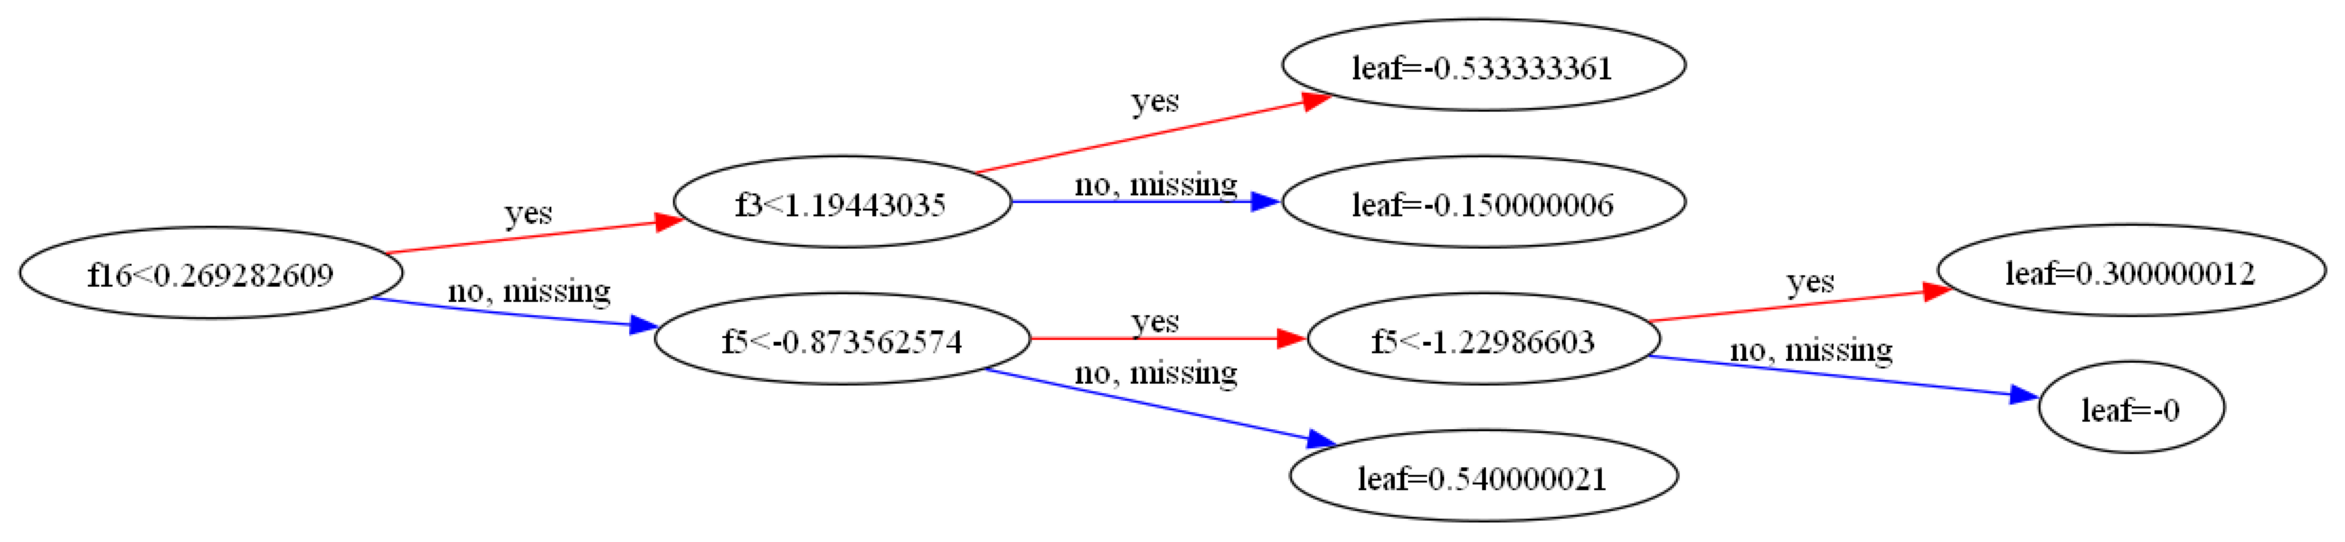

In [10]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(model, tree_idx=0, rankdir='LR', ax=ax)
plt.show()

In [11]:
print(sql_fmt)

SELECT
  1 / (
    EXP(
      -CASE
        WHEN "t0"."f16" < 0.26928260922431946
        THEN CASE
          WHEN "t0"."f3" < 1.1944303512573242
          THEN -0.5333333611488342
          ELSE -0.15000000596046448
        END
        ELSE CASE
          WHEN "t0"."f5" < -0.8735625743865967
          THEN CASE WHEN "t0"."f5" < -1.2298660278320312 THEN 0.30000001192092896 ELSE 0.0 END
          ELSE 0.5400000214576721
        END
      END
    ) + 1
  ) AS "pred",
  "f1"
FROM "DATA_TABLE" AS "t0"
SELECT
  1 / (
    EXP(
      -CASE
        WHEN "t0"."f16" < 0.26928260922431946
        THEN CASE
          WHEN "t0"."f3" < 1.1944303512573242
          THEN -0.5333333611488342
          ELSE -0.15000000596046448
        END
        ELSE CASE
          WHEN "t0"."f5" < -0.8735625743865967
          THEN CASE WHEN "t0"."f5" < -1.2298660278320312 THEN 0.30000001192092896 ELSE 0.0 END
          ELSE 0.5400000214576721
        END
      END
    ) + 1
  ) AS "pred",
  "f1"
FROM "DATA_TABLE" AS